# LC fitting

In [1]:
from utils import *
%reload_ext autoreload
%autoreload 2


name = 'z_host'
classes = np.load(f"data_folder/classes_{name}.npy", allow_pickle=True)

In [2]:
n_class = 14

sn_df = pd.DataFrame()
for i in range(0, n_class + 1):
    lc_df = classes[i].lc_df.copy()
    lc_df.index = np.array(lc_df.index) + (9999 + 1) * i

    sn_df = pd.concat([sn_df, lc_df])

['Ia']


c:\Users\aleja\Desktop\Supernovae Pipeline\Supernovae-Complete-Pipeline\.venv\lib\site-packages\iminuit\util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


x0: 1.18e-05 snana - 1.02e-05 sncosmo
x1: -1.66 snana - -1.25 sncosmo
c: -0.19 snana - -0.18 sncosmo

z = 0.53
μ snana: 42.388
μ sncosmo: 42.840 ± 0.196

μ theo: 42.421
μ sim snana: 42.424


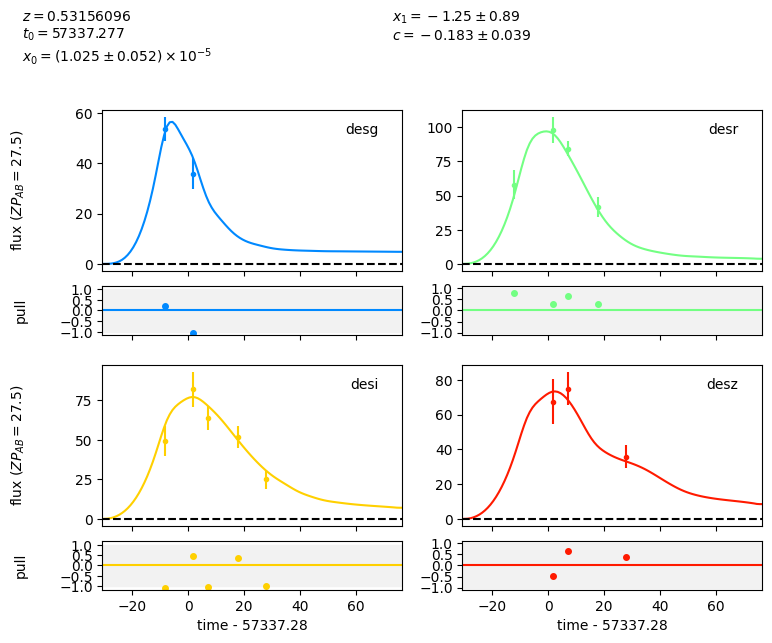

In [3]:
i_class, i = 14, 145_943

# sn_df = classes[i_class].lc_df
sn_df = sn_df[sn_df['PHOTFLAG'] != 0]

print(sn_df['SNTYPE'].unique())

sn_df_i = sn_df[sn_df.index == i].copy()

result, fit_model = lc_fitter(sn_df_i, plot=True, dust=False, model='salt3',
                              mcmc=False);

# fig, ax = classes[i_class].plotter(i, days=False, ls='')

# for f in ('des' + np.unique(sn_df_i['BAND'])):
#     min_mjd, max_mjd = sn_df_i['MJD'].min(), sn_df_i['MJD'].max()
#     mjd = np.arange(min_mjd, max_mjd)

#     salt2flux = fit_model.bandflux(f, mjd, zp=27.5, zpsys='AB')
#     ax.plot(mjd, salt2flux, label=f"sncosmo {f[-1]}", color=color_plot[f[-1]])

# plt.legend()
# plt.show()

# SALT2 parameters
x0, x1, c, m_B = [sn_df_i['SIM_SALT2' + i].values[0]
                  for i in ['x0', 'x1', 'c', 'mB']]

x0 *= 10 ** (-0.4 * 0.27)

x0_snc, x1_snc, c_snc = [fit_model[i] for i in ['x0', 'x1', 'c']]
x0_snc_err, x1_snc_err, c_snc_err = [result.errors[i] for i in ['x0', 'x1', 'c']]

print(f"x0: {x0:0.2e} snana - {x0_snc:0.2e} sncosmo")
print(f"x1: {x1:0.2f} snana - {x1_snc:0.2f} sncosmo")
print(f"c: {c:0.2f} snana - {c_snc:0.2f} sncosmo")

# Distance modulus calculation

M = -19.36
alpha, beta, gamma = 0.161, 3.12, 0.038
z = sn_df_i['REDSHIFT_FINAL'].values[0]

G_host = 1/2 if sn_df_i['HOSTGAL_LOGMASS'].values[0] > 10 else -1/2

mu_snana = (m_B - M +
            alpha * x1 - beta * c + gamma * G_host)

# SNCosmo distance modulus
peakphase = fit_model.source.peakphase('bessellb')
m_B_snc = fit_model.source.bandmag('bessellb', 'ab', peakphase)
M_snc = fit_model.source_peakabsmag('bessellb', 'ab')

mu_sncosmo = m_B_snc - M_snc + alpha * x1_snc - beta * c_snc + gamma * G_host

mu_sncosmo_err = np.sqrt((2.5 / np.log(10) * x0_snc_err / x0_snc)**2 +
                         (alpha * x1_snc_err)**2 +
                         (beta * c_snc_err)**2)

print(f'\nz = {z:0.2f}')
print(f"\u03BC snana: {mu_snana:0.3f}")
print(f"\u03BC sncosmo: {mu_sncosmo:0.3f} \u00b1 {mu_sncosmo_err:0.3f}")


# Theoretical distance modulus
mu_theo = distance_modulus(z, h=0.70, omega_m=0.3, omega_de=0.7)

print(f"\n\u03BC theo: {mu_theo:0.3f}")
print(f"\u03BC sim snana: {sn_df_i['SIM_DLMU'].values[0]:0.3f}")

In [4]:
sn_df = sn_df[sn_df['PHOTFLAG'] != 0] 
band = snc.get_bandpass('bessellb')

# data, index_discarded = lc_fit_summary(sn_df, band)
# data.to_pickle("data_folder/lc_params.pkl")

In [5]:
data = pd.read_pickle("data_folder/lc_params.pkl")

alpha, beta, gamma = 0.161, 3.12, 0.038
data['mu_marg'] = (data.m_B +
                   alpha * data.x1 - beta * data.c +
                   gamma * data.G_host
                   )

data['mu_marg_err'] = np.sqrt(data.m_B_err ** 2 +
                              (alpha * data.x1_err) ** 2 +
                              (beta * data.c_err) ** 2)

data = data[(data.mu_marg > 0) & (data.mu_marg_err < 0.07)]

data = data[(data.x1 < data.x1.mean() + 5 * data.x1.std()) &
            (data.x1 > data.x1.mean() - 5 * data.x1.std()) & 
            (data.c < data.c.mean() + 5 * data.c.std()) &
            (data.c > data.c.mean() - 5 * data.c.std())]

data['mu'] = (data.m_B - data.mabs_B.mean() +
              alpha * data.x1 - beta * data.c +
              gamma * data.G_host
              )

data['mu_err'] = np.sqrt(data.m_B_err**2 + data.mabs_B.std() ** 2 +
                         (alpha * data.x1_err)**2 + (beta * data.c_err)**2)

Mean: 0.17 Std: 0.74
3.86 > x1 > -3.53


<Axes: >

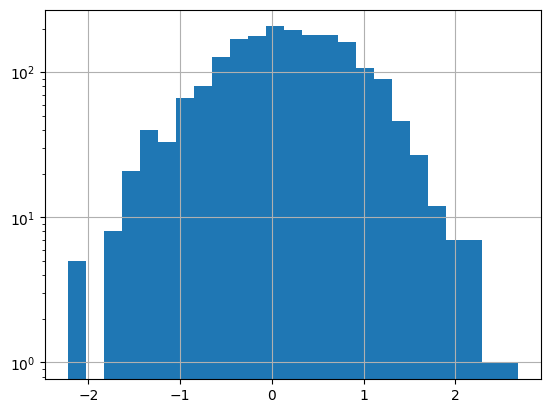

In [6]:
test = data.x1

print(f"Mean: {test.mean():0.2f}", f"Std: {test.std():0.2f}")
print(f"{test.mean() + 5 * test.std():0.2f}", f"> {test.name} >",
      f"{test.mean() - 5 * test.std():0.2f}")


test.hist(bins=25, log=True)


In [7]:
cov_matrix = np.cov(data[['m_B_err', 'x1_err', 'c_err']].values, rowvar=False)

np.sqrt(cov_matrix[0, 0] + alpha**2 * cov_matrix[1, 1] + beta**2 * cov_matrix[2, 2] +
        2 * alpha * cov_matrix[0, 1] - 2 * beta * cov_matrix[0, 2] -
        2 * alpha * beta * cov_matrix[1, 2]
        )

0.00616612141129314

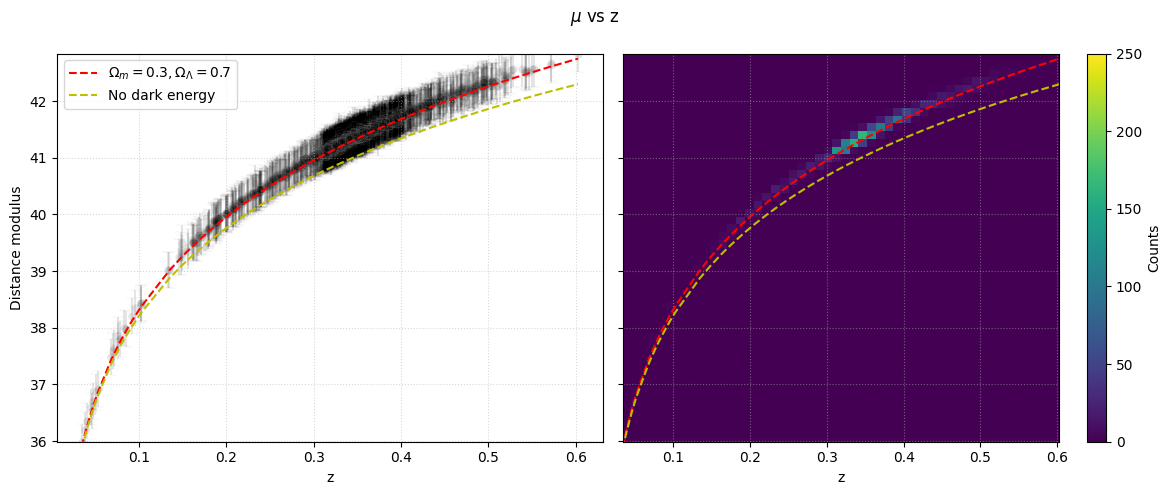

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, tight_layout=True)

ax[0].errorbar(data['z'], data['mu'], yerr=data['mu_err'], fmt='o',
               color='black', mew=0.3, mec='white', capsize=4, alpha=0.1,
               zorder=-1)

ax[1].hist2d(data['z'], data['mu'], bins=50, cmap='viridis', vmax=250)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
cbar.set_label('Counts')

z_plot = np.sort(data['z'])
for ax_i in ax:
    ax_i.plot(z_plot,
              distance_modulus(z_plot, omega_m=0.3, omega_de=0.7, h=0.7),
              'r--', label=r"$\Omega_m = 0.3, \Omega_{\Lambda} = 0.7$")

    ax_i.plot(z_plot,
              distance_modulus(z_plot, omega_m=1.0, omega_de=0, h=0.7),
              'y--', label=r"No dark energy")

    ax_i.set_xlabel("z")
    ax_i.grid(ls=':', alpha=0.5)

ax[0].set_ylabel(r"Distance modulus")
ax[0].legend()

fig.suptitle(r"$\mu$ vs z")

plt.show()

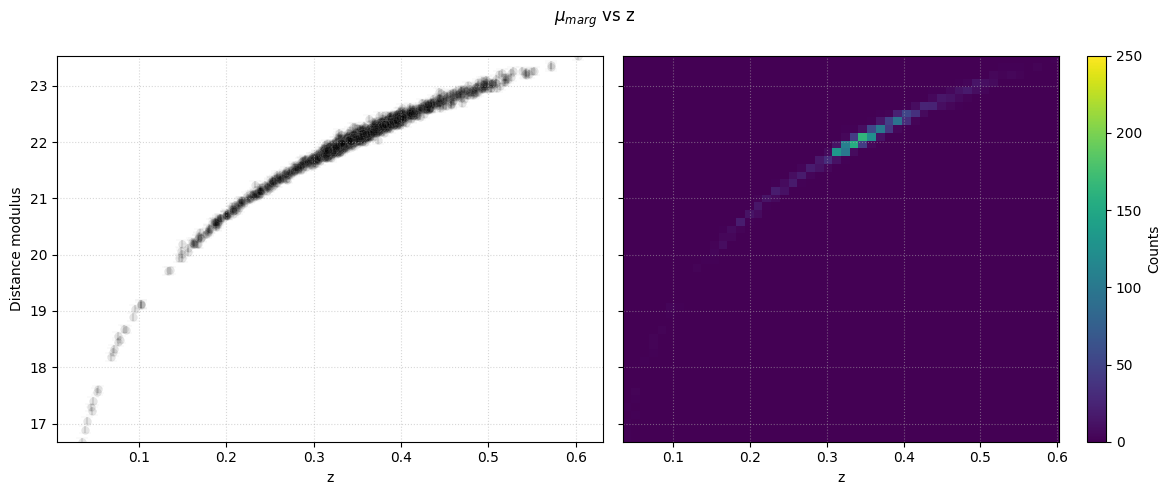

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, tight_layout=True)

ax[0].errorbar(data.z, data.mu_marg, yerr=data.mu_marg_err, fmt='o',
               color='black', mew=0.3, mec='white', capsize=4, alpha=0.1,
               zorder=-1)

ax[1].hist2d(data.z, data.mu_marg, bins=50, cmap='viridis', vmax=250)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
cbar.set_label('Counts')

ax[0].set_ylabel(r"Distance modulus")

for ax_i in ax:
    ax_i.set_xlabel("z")
    ax_i.grid(ls=':', alpha=0.5)

fig.suptitle(r"$\mu_{marg}$ vs z")

plt.show()

## Flat-$\Lambda$-CDM

In [10]:
def chi2_marg(params, data):
    omega_m = params[0]
    omega_de = 1 - omega_m
    mu_marg_th = distance_modulus(data.z, omega_m=omega_m, omega_de=omega_de)
    delta_mu_marg = data.mu_marg - mu_marg_th
    
    A = np.sum(delta_mu_marg ** 2 / data.mu_marg_err ** 2)
    B = np.sum(delta_mu_marg / data.mu_marg_err ** 2)
    C = np.sum(1 / data.mu_marg_err ** 2)
    
    return A + np.log(C / (2 * np.pi)) - B ** 2 / C

def log_prior(params):
    omega_m = params[0]
    
    cond_omega_m = 0.25 < omega_m < 0.35
    
    if cond_omega_m:
        return 0.0
    
    return -np.inf

def log_likelihood(params, data):
    return -0.5 * chi2_marg(params, data)

def log_posterior(params, data=data):
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(params, data)

def chi2(params, data):
    return -2 * log_posterior(params, data)

best_params = optimize.fmin(chi2, x0=[0.3], args=(data,))
print(best_params)

omega_m = best_params

Optimization terminated successfully.
         Current function value: 1233.314252
         Iterations: 9
         Function evaluations: 18
[0.29689453]


In [11]:
nwalkers = 1_000
param_initial = {'omega_m': omega_m + np.random.uniform(-0.05, 0.05, nwalkers)}

ndim = len(param_initial)
p0 = np.stack(list(param_initial.values()), axis=1)

# set up backend
filename = "data_folder/emcee/flat_lcdm.h5"
backend = emcee.backends.HDFBackend(filename)
# backend.reset(nwalkers, ndim) 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data,),
                                backend=backend)

# sampler.run_mcmc(p0, 1_000, progress=True);

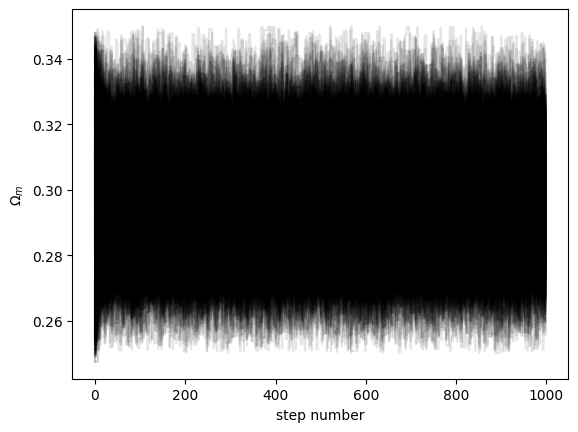

In [12]:
sampler = emcee.backends.HDFBackend(filename)

fig, ax = plt.subplots(nrows=ndim, ncols=1, sharex=True)
samples = sampler.get_chain()
labels = [r'$\Omega_m$']

ax.plot(samples[:, :, 0], 'k', alpha=0.1)
ax.set_ylabel(labels[0])
    
ax.set_xlabel("step number")
plt.show()

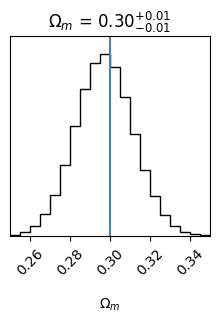

<IPython.core.display.Math object>

In [13]:
flat_samples = sampler.get_chain(discard=50, thin=5, flat=True)

figure = corner.corner(flat_samples, labels=labels,
                       show_titles=True, truths=[0.3])
plt.show()

summarize_mcmc(flat_samples, labels)

## $\Lambda$-CDM

In [14]:
def chi2_marg(params, data):
    omega_m, omega_de = params
    mu_marg_th = distance_modulus(data.z, omega_m=omega_m, omega_de=omega_de)
    delta_mu_marg = data.mu_marg - mu_marg_th
    
    A = np.sum(delta_mu_marg ** 2 / data.mu_marg_err ** 2)
    B = np.sum(delta_mu_marg / data.mu_marg_err ** 2)
    C = np.sum(1 / data.mu_marg_err ** 2)
    
    return A + np.log(C / (2 * np.pi)) - B ** 2 / C

def log_prior(params):
    omega_m, omega_de = params
    
    cond_omega_m = 0.1 < omega_m < 0.5
    cond_omega_de = 0.2 < omega_de < 0.8
    
    if cond_omega_m and cond_omega_de:
        return 0.0
    
    return -np.inf

def log_likelihood(params, data):
    return -0.5 * chi2_marg(params, data)

def log_posterior(params, data=data):
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(params, data)

def chi2(params, data):
    return -2 * log_posterior(params, data)

In [15]:
mu_marg_th = distance_modulus(data.z, omega_m=0.3, omega_de=0.7)
delta_mu_marg = np.array(data.mu_marg - mu_marg_th)
cov = np.diag(data.mu_marg_err**2)

A = np.transpose(delta_mu_marg) @ np.linalg.inv(cov) @ delta_mu_marg
B = np.transpose(delta_mu_marg) @ np.linalg.inv(cov) @ np.ones(len(delta_mu_marg))
C = np.transpose(np.ones(len(delta_mu_marg))) @ np.linalg.inv(cov) @ np.ones(len(delta_mu_marg))

In [16]:
best_params = optimize.fmin(chi2, x0=[0.3, 0.7], args=(data,))
print(best_params)

omega_m, omega_de = best_params

Optimization terminated successfully.
         Current function value: 1223.956392
         Iterations: 57
         Function evaluations: 106
[0.10000055 0.4263693 ]


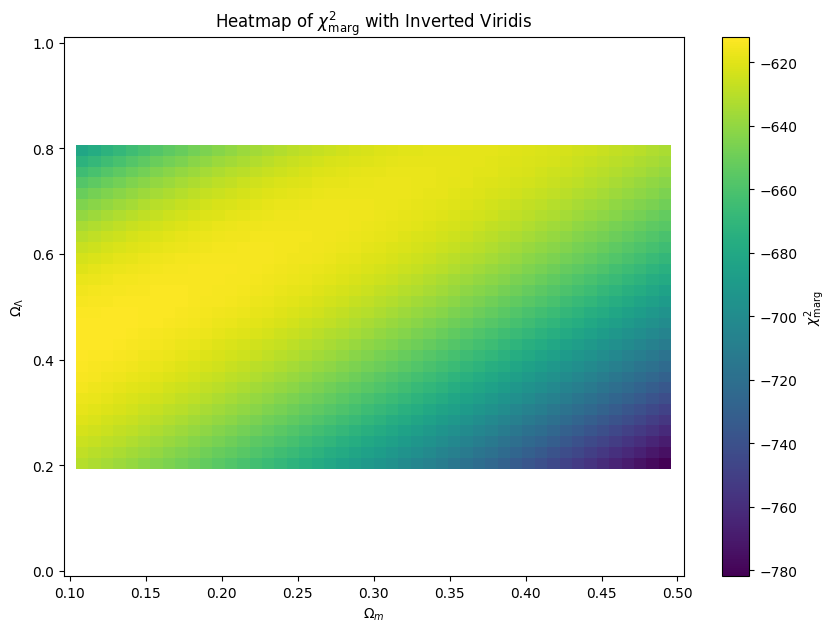

In [17]:
# Define ranges for omega_m and omega_de
omega_m_vals = np.linspace(0.1, 0.5, 25*2)
omega_de_vals = np.linspace(0, 1., 25*2)
Omega_m, Omega_de = np.meshgrid(omega_m_vals, omega_de_vals)

# Compute chi2_marg for each pair
Chi2_marg = np.zeros_like(Omega_m)
for i in range(Omega_m.shape[0]):
    for j in range(Omega_m.shape[1]):
        Chi2_marg[i, j] = log_posterior([Omega_m[i, j], Omega_de[i, j]], data)

# Plot heatmap with inverse viridis colormap
plt.figure(figsize=(10, 7))
heatmap = plt.pcolormesh(Omega_m, Omega_de, Chi2_marg, cmap='viridis', shading='auto')
plt.colorbar(heatmap, label=r'$\chi^2_{\mathrm{marg}}$')
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title(r'Heatmap of $\chi^2_{\mathrm{marg}}$ with Inverted Viridis')
plt.show()


In [18]:
nwalkers = 1_000
param_initial = {'omega_m': omega_m + np.random.uniform(-0.3, 0.3, nwalkers),
                 'omega_de': omega_de + np.random.uniform(-0.3, 0.3, nwalkers)
                 }

ndim = len(param_initial)
p0 = np.stack(list(param_initial.values()), axis=1)

# set up backend
filename = "data_folder/emcee/lcdm.h5"
backend = emcee.backends.HDFBackend(filename)
# backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data,),
                                backend=backend)

# sampler.run_mcmc(p0, 1_000, progress=True);

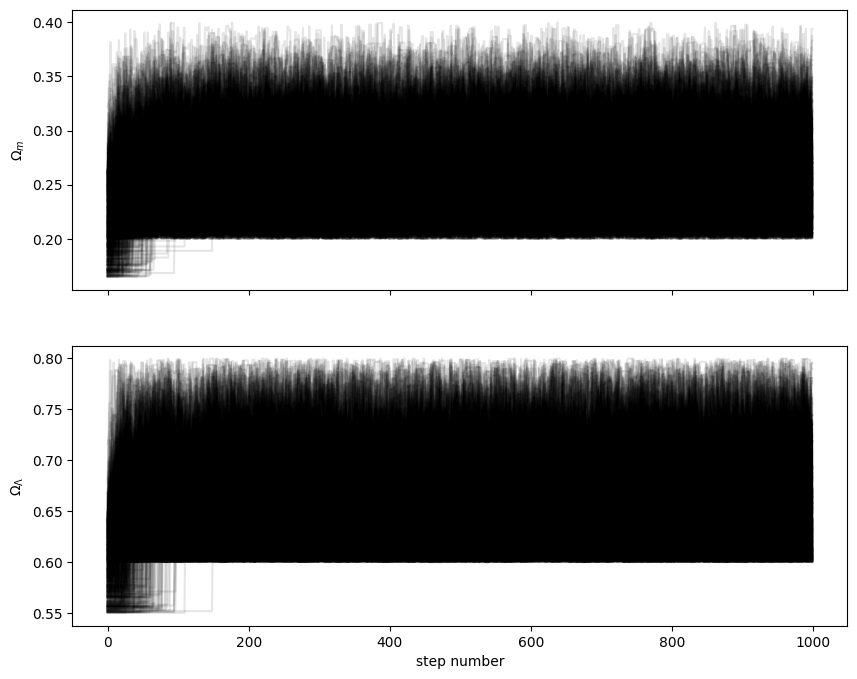

In [19]:
sampler = emcee.backends.HDFBackend(filename)

fig, ax = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = [r'$\Omega_m$', r'$\Omega_{\Lambda}$', r'$\mathcal{M}$']

for i, axis in enumerate(ax):
    axis.plot(samples[:, :, i], 'k', alpha=0.1)
    axis.set_ylabel(labels[i])
    
axis.set_xlabel("step number")
plt.show()

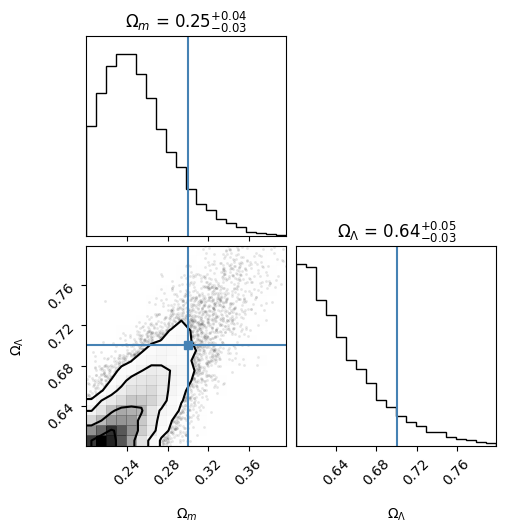

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
flat_samples = sampler.get_chain(discard=700, thin=25, flat=True)

figure = corner.corner(flat_samples, labels=labels,
                       show_titles=True, truths=[0.3, 0.7])
plt.show()

summarize_mcmc(flat_samples, labels)

## Flat-$w$-CDM

In [21]:
def chi2_marg(params, data):
    omega_m, w = params
    omega_de = 1 - omega_m
    mu_marg_th = distance_modulus(data.z, omega_m=omega_m, omega_de=omega_de,
                                  w_0=w)
    delta_mu_marg = data.mu_marg - mu_marg_th
    
    A = np.sum(delta_mu_marg ** 2 / data.mu_marg_err ** 2)
    B = np.sum(delta_mu_marg / data.mu_marg_err ** 2)
    C = np.sum(1 / data.mu_marg_err ** 2)
    
    return A + np.log(C / (2 * np.pi)) - B ** 2 / C

def log_prior(params):
    omega_m, w = params
    
    cond_omega_m = 0.2 < omega_m < 0.4
    cond_w = -1.5 < w < -0.5
    
    if cond_omega_m and cond_w:
        return 0.0
    
    return -np.inf

def log_likelihood(params, data):
    return -0.5 * chi2_marg(params, data)

def log_posterior(params, data=data):
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(params, data)

def chi2(params, data):
    return -2 * log_posterior(params, data)

best_params = optimize.fmin(chi2, x0=[0.3, -1], args=(data,))
print(best_params)

omega_m, w = best_params

Optimization terminated successfully.
         Current function value: 1228.120667
         Iterations: 56
         Function evaluations: 103
[ 0.20000017 -0.79730916]


In [22]:
nwalkers = 1_000
param_initial = {'omega_m': omega_m + np.random.uniform(-0.05, 0.05, nwalkers),
                 'w': w + np.random.uniform(-0.05, 0.05, nwalkers)
                 }

ndim = len(param_initial)
p0 = np.stack(list(param_initial.values()), axis=1)

# set up backend
filename = "data_folder/emcee/flat_wcdm.h5"
backend = emcee.backends.HDFBackend(filename)
# backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data,),
                                backend=backend)

# sampler.run_mcmc(p0, 1_000, progress=True);

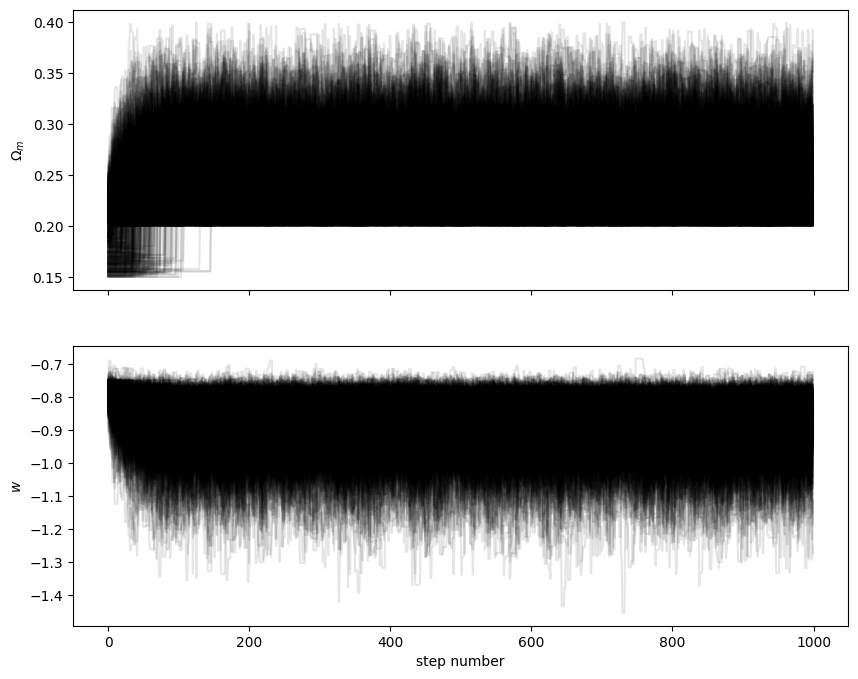

In [23]:
sampler = emcee.backends.HDFBackend(filename)

fig, ax = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = [r'$\Omega_m$', r'$w$']

for i, axis in enumerate(ax):
    axis.plot(samples[:, :, i], 'k', alpha=0.1)
    axis.set_ylabel(labels[i])
    
axis.set_xlabel("step number")
plt.show()

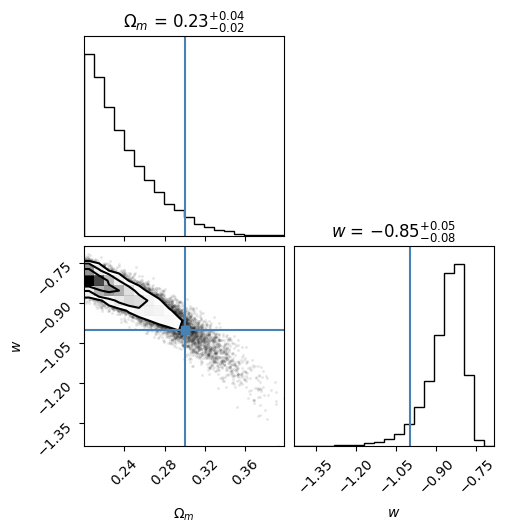

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [24]:
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)

figure = corner.corner(flat_samples, labels=labels,
                       show_titles=True, truths=[0.3, -1])
plt.show()

summarize_mcmc(flat_samples, labels)

## Flat-$w_0 w_a$-CDM

In [25]:
def chi2_marg(params, data):
    omega_m, w_0, w_a = params
    omega_de = 1 - omega_m
    mu_marg_th = distance_modulus(data.z, omega_m=omega_m, omega_de=omega_de,
                                  w_0=w_0, w_a=w_a)
    delta_mu_marg = data.mu_marg - mu_marg_th
    
    A = np.sum(delta_mu_marg ** 2 / data.mu_marg_err ** 2)
    B = np.sum(delta_mu_marg / data.mu_marg_err ** 2)
    C = np.sum(1 / data.mu_marg_err ** 2)
    
    return A + np.log(C / (2 * np.pi)) - B ** 2 / C

def log_prior(params):
    omega_m, w_0, w_a = params
    
    cond_omega_m = 0.2 < omega_m < 0.4
    cond_w_0 = -1.5 < w_0 < -0.5
    cond_w_a = -0.25 < w_a < 0.25
    
    if cond_omega_m and cond_w_0 and cond_w_a:
        return 0.0
    
    return -np.inf

def log_likelihood(params, data):
    return -0.5 * chi2_marg(params, data)

def log_posterior(params, data=data):
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(params, data)

def chi2(params, data):
    return -2 * log_posterior(params, data)

best_params = optimize.fmin(chi2, x0=[0.3, -1, 0], args=(data,))
print(best_params)

omega_m, w_0, w_a = best_params

Optimization terminated successfully.
         Current function value: 1228.126478
         Iterations: 81
         Function evaluations: 150
[ 2.00000000e-01 -7.97571152e-01  7.41441044e-04]


In [27]:
nwalkers = 1_000
param_initial = {'omega_m': omega_m + np.random.uniform(-0.05, 0.05, nwalkers),
                 'w0': w_0 + np.random.uniform(-0.05, 0.05, nwalkers),
                 'wa': w_a + np.random.uniform(-0.05, 0.05, nwalkers)
                 }

ndim = len(param_initial)
p0 = np.stack(list(param_initial.values()), axis=1)

# set up backend
filename = "data_folder/emcee/flat_w0wacdm.h5"
backend = emcee.backends.HDFBackend(filename)
# backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data,),
                                backend=backend)

# sampler.run_mcmc(p0, 1_000, progress=True);

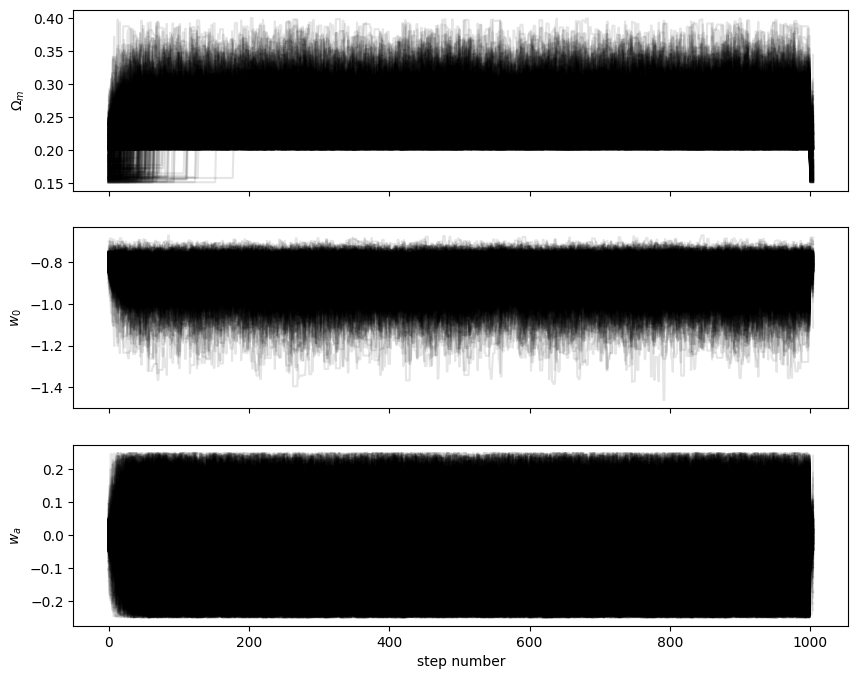

In [28]:
sampler = emcee.backends.HDFBackend(filename)

fig, ax = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = [r'$\Omega_m$', r'$w_0$', r'$w_a$']

for i, axis in enumerate(ax):
    axis.plot(samples[:, :, i], 'k', alpha=0.1)
    axis.set_ylabel(labels[i])
    
axis.set_xlabel("step number")
plt.show()

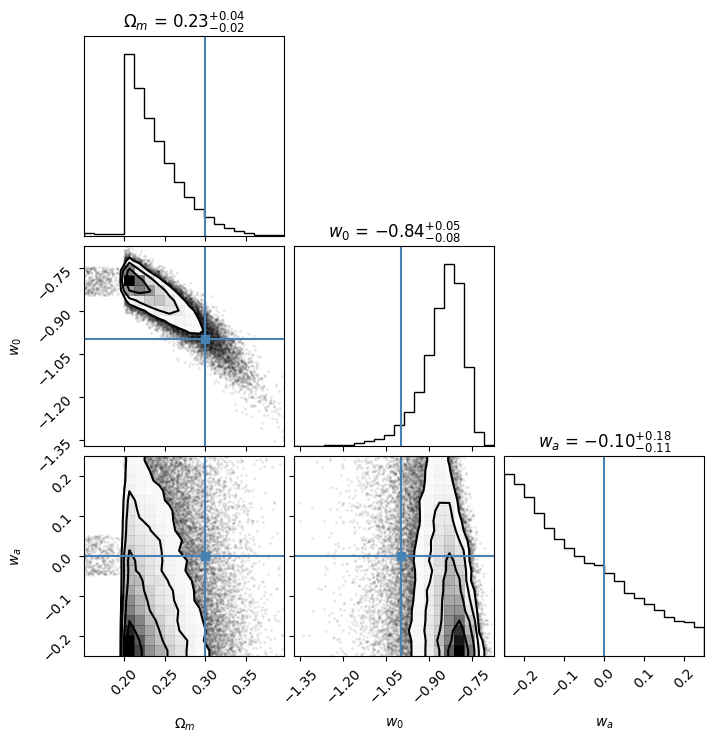

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)

figure = corner.corner(flat_samples, labels=labels,
                       show_titles=True, truths=[0.3, -1, 0])
plt.show()

summarize_mcmc(flat_samples, labels)

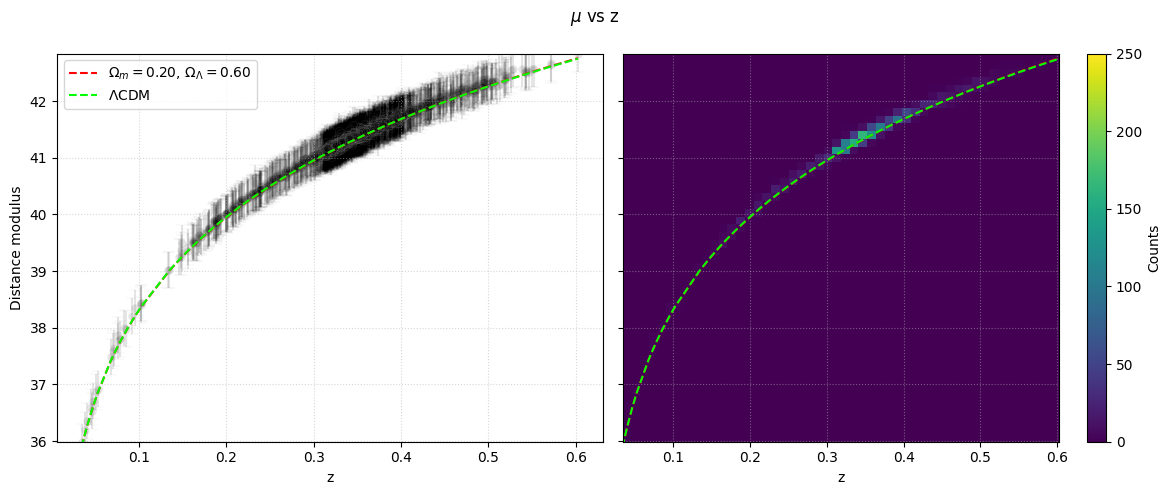

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, tight_layout=True)

ax[0].errorbar(data['z'], data['mu'], yerr=data['mu_err'], fmt='o',
               color='black', mew=0.3, mec='white', capsize=4, alpha=0.1,
               zorder=-1)

ax[1].hist2d(data['z'], data['mu'], bins=50, cmap='viridis', vmax=250)
cbar = plt.colorbar(ax[1].collections[0], ax=ax[1])
cbar.set_label('Counts')

z_plot = np.sort(data['z'])

label = (r"$\Omega_m = $" + f"{omega_m:0.2f}, " +
         r"$\Omega_{\Lambda} = $" + f"{omega_de:0.2f}")

for ax_i in ax:
    ax_i.plot(z_plot,
              distance_modulus(z_plot, omega_m=omega_m, omega_de=omega_de, h=0.7),
              'r--', label=label)
    
    ax_i.plot(z_plot,
            distance_modulus(z_plot, omega_m=0.3, omega_de=0.7, h=0.7),
            ls='--', color='lime', label=r"$\Lambda$CDM")

    ax_i.set_xlabel("z")
    ax_i.grid(ls=':', alpha=0.5)

ax[0].set_ylabel(r"Distance modulus")
ax[0].legend()

fig.suptitle(r"$\mu$ vs z")

plt.show()